In [304]:
def exp_file_write(file_path, input_str, open_mode="a"):
    with open(file_path, open_mode) as f:
        f.write(input_str)

#I: Uncomment the following lines to consolidate the
#I# efx_emd_hesstrace_v0-31 files into a single file
#I# for efd and efr.   
efd_fp = './efd_emd_hesstrace_v0-31.log'
efr_fp = './efr_emd_hesstrace_v0-31.log'
# exp_file_write(efd_fp, "", "w")
# exp_file_write(efr_fp, "", "w")  

# efd_fps = list()
# efr_fps = list()

# for i in range(0, 10600, int(10600/8)):
#     curr_efd_fp = f'./efd_emd_hesstrace_v0-31_b{i}-{int(i+10600/8)}.log'
#     with open(curr_efd_fp, "r") as c_efd:
#         for line in c_efd:
#             exp_file_write(efd_fp, line)

#     curr_efr_fp = f'./efr_emd_hesstrace_v0-31_b{i}-{int(i+10600/8)}.log'
#     with open(curr_efr_fp, "r") as c_efr:
#         for line in c_efr:
#             exp_file_write(efr_fp, line)

In [312]:
num_lines = 0

bi_to_demd  = dict()
bi_to_ht    = dict()
bi_to_count = dict()

didnt_converge = 0
htdc = dict()

print("Summing EMD values for each bit")
# with open("./efr_emd_hesstrace_v0-31_b0-1325-forloop-2.log", "r") as f:
# with open("./efd_emd_hesstrace_v0-31_wo_kernel_assign.log", "r") as f:
# with open("../efr_emd_hesstrace_v0-31_b0-1325-forloop.log", "r") as f:
with open("../test_kernel_assign_v0-31_b6_efr.log", "r") as f:
# with open(efr_fp, "r") as f:
    for li, line in enumerate(f):
        if li > 0:
            try:
                curr_vi_bi, curr_emd, curr_htd = [substr.strip() for substr in line.split("|")]
                vi, bi = [int(val) for val in curr_vi_bi[1:-1].split(",")]
                num_lines += 1
                try:
                    bi_to_demd[bi] += float(curr_emd)
                    
                    bi_to_ht[bi] += float(curr_htd.split("'conv2d_0_m':")    [1].split(",")[0].strip())
                    bi_to_ht[bi] += float(curr_htd.split("'encoded_vector':")[1].split(",")[0].strip())

                    bi_to_count[bi] += 1
                except KeyError:
                    bi_to_demd[bi]  = float(curr_emd)

                    if ("'conv2d_0_m':" in curr_htd) and ("'encoded_vector':" in curr_htd):
                        bi_to_ht[bi]  = float(curr_htd.split("'conv2d_0_m':")    [1].split(",")[0].strip())
                        bi_to_ht[bi] += float(curr_htd.split("'encoded_vector':")[1].split(",")[0].strip())
                    else:
                        # print(f"Encoder Layers Didn't Converge #{didnt_converge}: {curr_htd}")
                        didnt_converge += 1
                        try:
                            htdc[bi] += 1 
                        except KeyError:
                            htdc[bi]  = 1

                    bi_to_count[bi] = 1
                    #print(f"New bi from {curr_vi_bi} at line number: {li}")
            except ValueError:
                pass #print(line)
        # if len(bi_to_demd.keys()) == 10000:
        #     break 


print("Averaging EMD values for each bit")
for bi in bi_to_demd.keys():
    bi_to_demd[bi]  = bi_to_demd[bi]/bi_to_count[bi]

for bi in bi_to_ht.keys():
    bi_to_ht[bi]  = bi_to_ht[bi]/bi_to_count[bi]

print(num_lines)

Summing EMD values for each bit
Averaging EMD values for each bit
32


In [313]:
len(set(htdc.keys()))

0

In [314]:
def get_wi(i_bi, i_bw):
    return int(i_bi/i_bw)

def get_wbi(i_bi, i_bw):
    return int(i_bi%i_bw)

wis  = list()
bis  = list()
demd = list()
ht = list()

for bi in bi_to_demd.keys():
    wis.append(get_wi(bi,5))
    bis.append(get_wbi(bi,5))
    if get_wbi(bi,5) == 0:
        demd.append(bi_to_demd[bi]) #demd.append(1.6)
    else:
        demd.append(bi_to_demd[bi])

for bi in bi_to_ht.keys():
    # wis.append(get_wi(bi,5))
    # bis.append(get_wbi(bi,5))
    if get_wbi(bi,5) == 0:
        ht.append(bi_to_ht[bi]) #demd.append(1.6)
    else:
        ht.append(bi_to_ht[bi])

In [315]:
print(len ( bi_to_demd.keys()))

1


TypeError: Dimensions of C (5, 1) are incompatible with X (1) and/or Y (1); see help(pcolormesh)

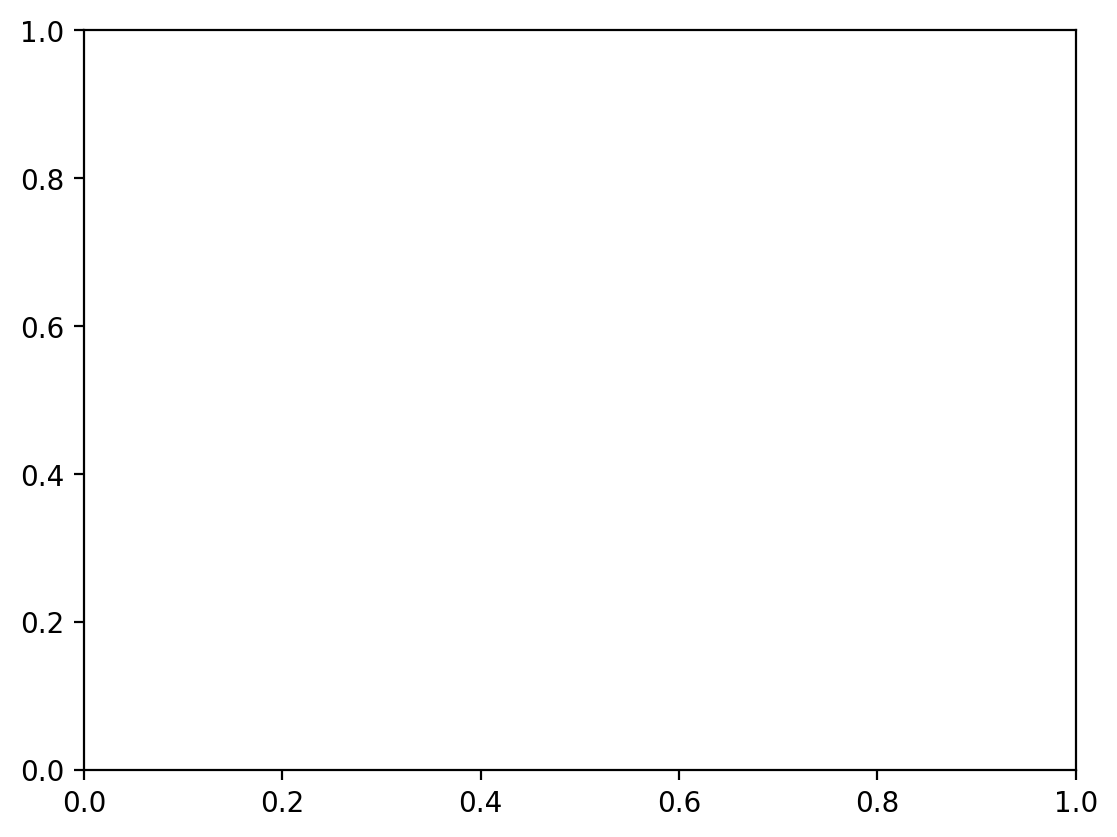

In [316]:
'''
https://gist.github.com/teechap/9c066a9ab054cc322877
Most heatmap tutorials I found online use pyplot.pcolormesh with random sets of
data from Numpy; I just needed to plot x, y, z values stored in lists--without
all the Numpy mumbo jumbo. Here I have code to plot intensity on a 2D array, and
I only use Numpy where I need to (pcolormesh expects Numpy arrays as inputs).
'''
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

#here's our data to plot, all normal Python lists
y = sorted(list(set(bis))) #[1, 2, 3, 4, 5]
x = sorted(list(set(wis)))            #[0.1, 0.2, 0.3, 0.4, 0.5]

# intensity = [
#     [5, 10, 15, 20, 25],
#     [30, 35, 40, 45, 50],
#     [55, 60, 65, 70, 75],
#     [80, 85, 90, 95, 100],
#     [105, 110, 115, 120, 125]
# ]

intensity = list()
for wi in sorted(list(set(wis))):
    rel_demds = demd[wi*5:(wi+1)*5] 
    if len(rel_demds) < 5:
        rel_demds += [0.0 for _ in range(5-len(rel_demds))]
    intensity.append(rel_demds)

# intensity[0][0] = 25

#setup the 2D grid with Numpy
x, y = np.meshgrid(x, y)

#convert intensity (list of lists) to a numpy array for plotting
intensity = np.array(intensity).transpose()

#now just plug the data into pcolormesh, it's that easy!
plt.pcolormesh(x, y, intensity)
plt.colorbar() #need a colorbar to show the intensity scale
# plt.title('Delta EMD\n$\\frac{\sum{}{}|\mathrm{EMD}_{Faulty} - \mathrm{EMD}_{Base}|}{\mathrm{V}}$')
plt.title('Average EMD\n$\\frac{\sum{}{}\mathrm{EMD}_{Faulty}}{\mathrm{V}}$')
plt.ylabel("Bit Index")
plt.xlabel("Weight Index")
# plt.rcParams["figure.figsize"] = (,3)
plt.xlim(0,250)
plt.show() #boom

In [317]:
num_lines = 0

og_bi_to_demd  = dict()
og_bi_to_count = dict()

print("Summing EMD values for each bit")
with open("/home/anmeza/GitHub/fastml-science/sensor-data-compression/efr_val_inputs_0-31_with_eager_exec copy.log") as f:
    for li, line in enumerate(f):
        if li > 0:
            try:
                curr_vi_bi, curr_emd = [substr.strip() for substr in line.split("|")]
                vi, bi = [int(val) for val in curr_vi_bi[1:-1].split(",")]
                num_lines += 1
                try:
                    og_bi_to_demd[bi]  += float(curr_emd)
                    og_bi_to_count[bi] += 1
                except KeyError:
                    og_bi_to_demd[bi]  = float(curr_emd)
                    og_bi_to_count[bi] = 1
                    #print(f"New bi from {curr_vi_bi} at line number: {li}")
            except ValueError:
                pass #print(line)
        # if len(bi_to_demd.keys()) == 10000:
        #     break 


print("Averaging EMD values for each bit")
for bi in og_bi_to_demd.keys():
    og_bi_to_demd[bi]  = og_bi_to_demd[bi]/og_bi_to_count[bi]

print(num_lines)

Summing EMD values for each bit
Averaging EMD values for each bit
339200


1


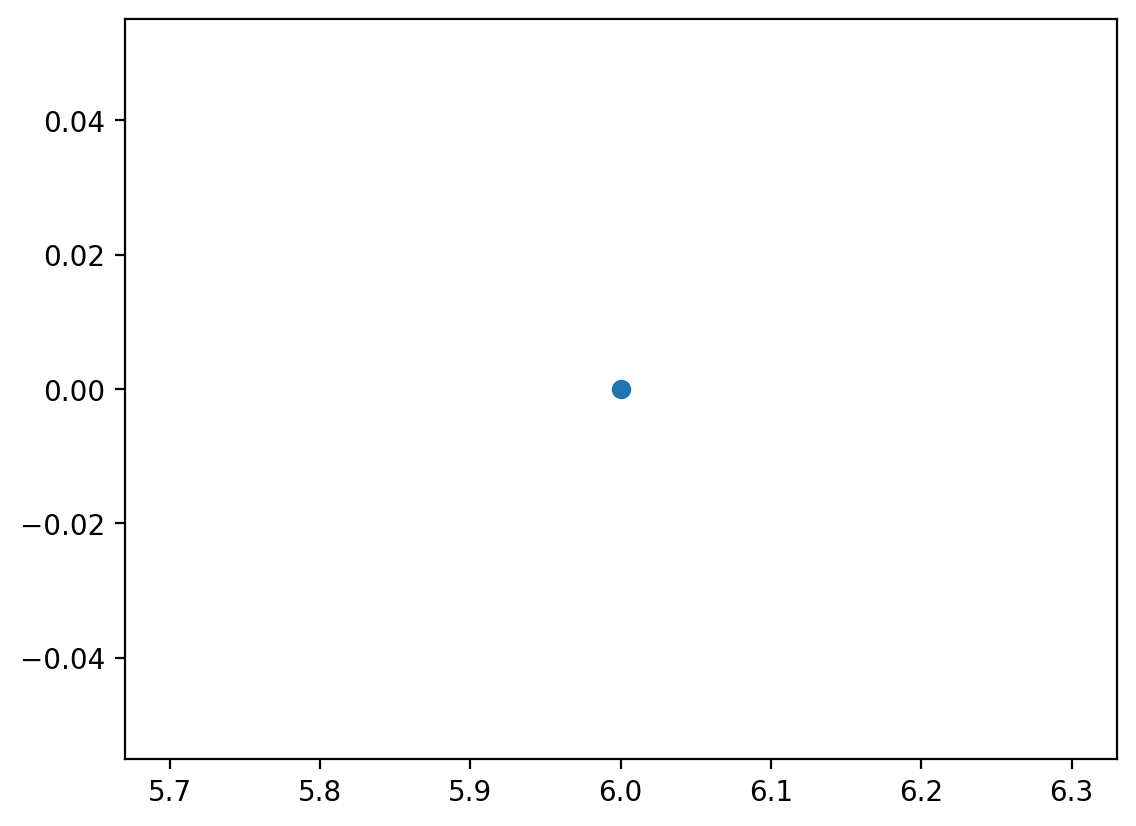

In [318]:
diff_x = list()
diff_y = list()

same = 0
for k in sorted(bi_to_demd.keys()):
    # if k < 47:
    diff_x.append(k)
    diff_y.append(og_bi_to_demd[k] - bi_to_demd[k])
    if -0.00000005 < (og_bi_to_demd[k] - bi_to_demd[k]) < 0.00000005:
        same +=1
print(same)

plt.plot(diff_x, diff_y, linestyle='--', marker='o')
plt.show()

7


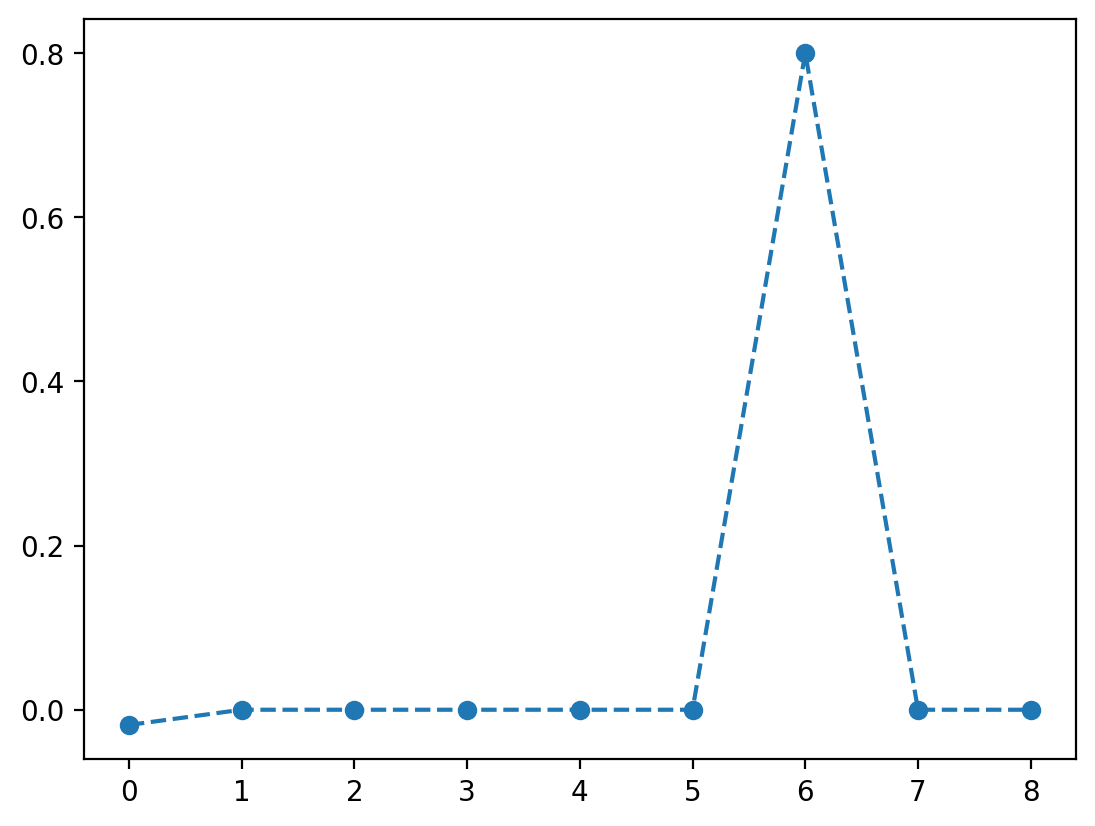

In [311]:
diff_x = list()
diff_y = list()

same = 0
for k in sorted(bi_to_demd.keys()):
    # if k < 47:
    diff_x.append(k)
    diff_y.append(og_bi_to_demd[k] - bi_to_demd[k])
    if -0.00000005 < (og_bi_to_demd[k] - bi_to_demd[k]) < 0.00000005:
        same +=1
print(same)

plt.plot(diff_x, diff_y, linestyle='--', marker='o')
plt.show()

3200


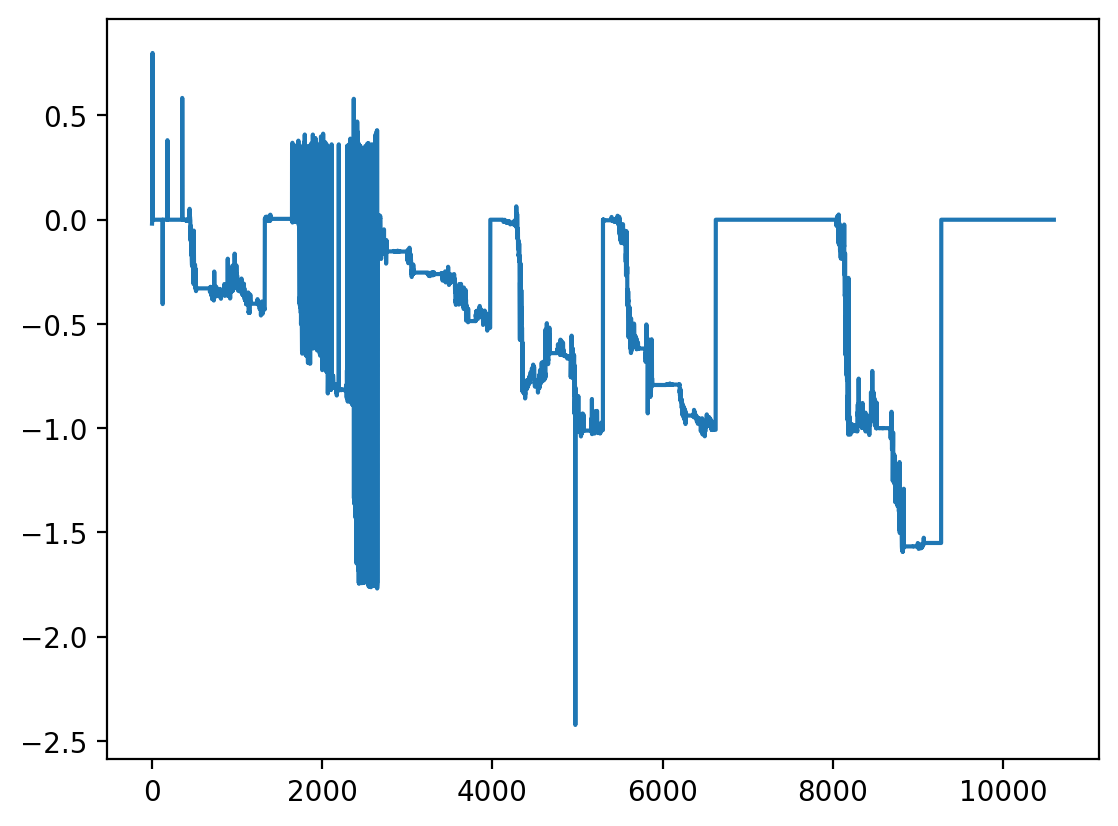

In [236]:
diff_x = list()
diff_y = list()

same = 0
for k,v in bi_to_demd.items():
    # if k < 140:
    diff_x.append(k)
    diff_y.append(og_bi_to_demd[k] - v)
    if -0.00000005 < (og_bi_to_demd[k] - v) < 0.00000005:
        same +=1
print(same)

plt.plot(diff_x, diff_y)
plt.show()